In [ ]:
### https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

import os
import sys
import pandas as pd
import numpy as np
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn knižnice
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

cwd = os.getcwd()

# inicializácia mojich funkcií
sys.path.insert(1,cwd + '/insAInDev_Tools/')
import insAInDev_Processor as insAIProc

### Načítanie datasetu

In [12]:
# nastavenie vizualizácie full text length
pd.set_option('display.max_colwidth', -1)

# separátor stĺpcov sa používa tab (pre čiarku to je sep=',')
# quoting=3 je pre odstránenie úvodzoviek v texte 
df = pd.read_csv(cwd + '/Datasets/Reviews/Restaurant_Reviews.tsv',sep='\t', error_bad_lines=False, quoting=3)

# zobrazenie prvých 3 riadkov 
df.head(10)

<ipython-input-12-342da948e511>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.,0
8,The fries were great too.,1
9,A great touch.,1


### Konkretizácia dát 

In [13]:
# pomenovanie stĺpcov z datasetu
col = ['Review', 'Liked']
# pridelenie stĺpcov z dataframeu
df = df[col]
# úprava datasetu (vymazanie riadkov s prázdnym textom)
df = df[pd.notnull(df['Review'])]
# definovanie konkrtétnych stĺpcov z dataframeu
df.columns = ['Review', 'Liked']

### Vizualizácia v grafe

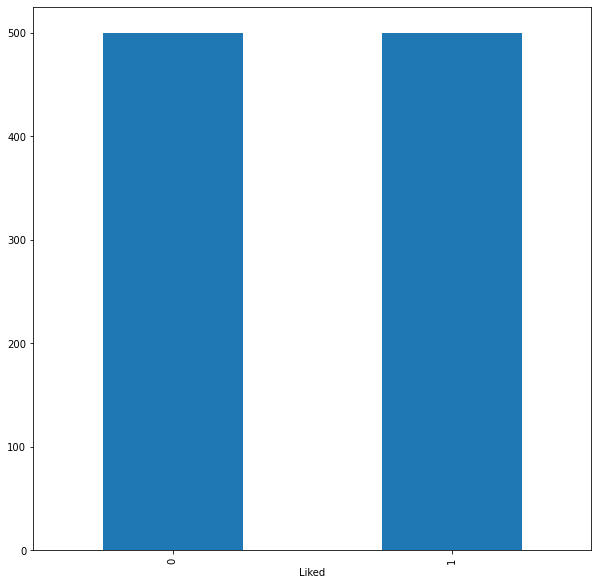

In [14]:
# definovanie veľkosti grafu
fig = plt.figure(figsize=(10,10))

# zoskupenie počtu recenzii rozdelené podľa Liked
df.groupby('Liked').Review.count().plot.bar(ylim=0)

# zobrazenie grafu
plt.show()

### Odstránenie Stop Words

### Výnimky pre stop words

In [15]:
cleanedCorpus = insAIProc.removeStopwordfromDataframeColumn(df,'not')

print(cleanedCorpus)

['wow love place', 'crust not good', 'not tasti textur nasti', 'stop late may bank holiday rick steve recommend love', 'select menu great price', 'get angri want damn pho', 'honeslti tast fresh', 'potato like rubber could tell made ahead time kept warmer', 'fri great', 'great touch', 'servic prompt', 'would not go back', 'cashier care ever say still end wayyy overpr', 'tri cape cod ravoli chicken cranberri mmmm', 'disgust pretti sure human hair', 'shock sign indic cash', 'high recommend', 'waitress littl slow servic', 'place not worth time let alon vega', 'not like', 'burritto blah', 'food amaz', 'servic also cute', 'could care less interior beauti', 'perform', 'right red velvet cake ohhh stuff good', 'never brought salad ask', 'hole wall great mexican street taco friend staff', 'took hour get food tabl restaur food luke warm sever run around like total overwhelm', 'worst salmon sashimi', 'also combo like burger fri beer decent deal', 'like final blow', 'found place accid could not hap

### Vektorizácia

In [16]:
# inicializácia vektorizácie
cv = TfidfVectorizer(max_features = 1000)
# inicializácie features a labels
features = cv.fit_transform(cleanedCorpus).toarray()
label = df.Liked

### Rozdelenie datasetu (training, test)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size = 0.20, random_state = 0)

### Porovnanie modelov

In [18]:
# inicializácia modelov
models = [
    RandomForestClassifier(n_estimators=200, max_depth=30, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# crossvalidation splitting strategy
CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
# iterácia medzi jednotlivými modelmi
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, label, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

### Vizualizácia porovnania modelov

model_name
LinearSVC                 0.781
LogisticRegression        0.776
MultinomialNB             0.762
RandomForestClassifier    0.781
Name: accuracy, dtype: float64


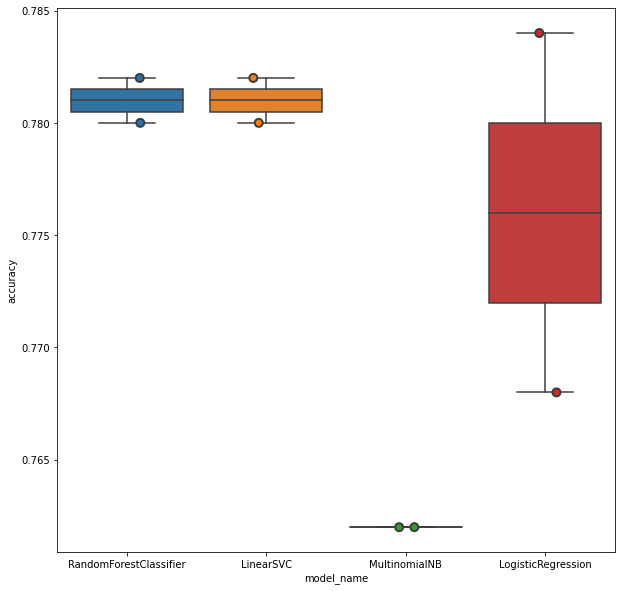

In [22]:
# výpis výsledkov presnosti po modeloch
print(cv_df.groupby('model_name').accuracy.mean())

# grafické znázornenie modelov a ich úspešnosti (min percentil, max percentil, medián)
fig = plt.figure(figsize=(10,10))

# nastavenie grafu
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

#. zobrazenie grafu
plt.show()

### Tréning modelu

In [23]:
# inicializácia modelu
classifier = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=0)
# tréning modelu
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=200, random_state=0)

### Predikcia

In [24]:
y_pred = classifier.predict(X_test)

### Vizualizácia výsledkov

0.755


<Figure size 720x720 with 0 Axes>

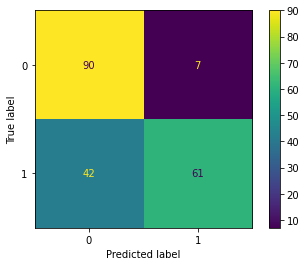

In [26]:
# výpis percentuálnej presnosti modelu
print(accuracy_score(y_test, y_pred))

# inicializácia grafu
plot_confusion_matrix(classifier, X_test, y_test)
# zobrazenie grafu
plt.show()